## Is the ocean in thermal wind balance? 

This notebook is motivated by our lack of understanding of gyres in positive buoyancy experiments, wherein we observe a significant change in the spatial structure of subtropical and subpolar gyres, especially in the Northern Hemisphere. A hypothesis is that thermal wind balance could be one of the mechanisms by which this spatial restructuring occurs in these gyres. To test our hypothesis, we first see whether, in our control simulation, the ocean is in thermal wind balance. In our calculation, we also do a geostrophy check, which along with hydrostatic balance, forms the framework for thermal wind balance solution. The geostrophic balance is given as:

\begin{equation}
\boldsymbol{u} = -\frac{\boldsymbol{\hat{k}} \times \boldsymbol{\nabla} p}{\rho_0 f}.
\end{equation}

The equations governing the thermal wind balance is given by:

\begin{equation}
\frac{\partial \boldsymbol{u}}{\partial z} = - \Big (\frac{g}{\rho_0 f} \Big )\boldsymbol{\hat{k}} \times \boldsymbol{\nabla} \rho.
\end{equation}

The calculation of geostrophic balance requires very precise calculations of pressure, and we do it in an iterative fashion. We find that the ocean, over longer (~decadal) time scales is in geostrophic as well as thermal wind balance. This is a useful result - we can now test the thermal wind relation for positive buoyancy experiments to check whether gyres change their shape owing to thermal wind balance anomalies or not.

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rc('xtick', labelsize = 20) 
matplotlib.rc('ytick', labelsize = 20)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm

from xhistogram.xarray import histogram

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

2022-08-25 13:44:50,463 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56374642.gadi-pbs/dask-worker-space/worker-t6t9eeb8', purging
2022-08-25 13:44:50,467 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56374642.gadi-pbs/dask-worker-space/worker-e11wc3np', purging
2022-08-25 13:44:50,472 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/56374642.gadi-pbs/dask-worker-space/worker-zw78k2uv', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34723,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:44447,Total threads: 4
Dashboard: /proxy/34155/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41325,


In [4]:
db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_control.db'
session = cc.database.create_session(db)
expt = '025deg_jra55_ryf_control'

In [5]:
grav = 9.81
omega = (2 * np.pi)/86400
r0 = 6.371 * 10**6

In [6]:
start_time = '2282-01-01'
end_time = '2301-12-31'

In [7]:
def var_td(variable):
    out = cc.querying.getvar(expt = expt, variable = variable, session = session, start_time = start_time, end_time = end_time, use_cftime = True)
    out = out.sel(time = slice(start_time, end_time)).mean('time')
    return out

def var_ti(variable):
    out = cc.querying.getvar(expt = expt, variable = variable, session = session, n = 1)
    return out

In [12]:
u = var_td('u').sel(xu_ocean = slice(-90, 10)).sel(yu_ocean = slice(20, 65))
v = var_td('v').sel(xu_ocean = slice(-90, 10)).sel(yu_ocean = slice(20, 65))
T = var_td('temp').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65))
S = var_td('salt').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65))
eta = var_td('sea_level').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65))
dz = var_td('dzt').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65))

x = var_ti('xt_ocean').sel(xt_ocean = slice(-90, 10))
y = var_ti('yt_ocean').sel(yt_ocean = slice(20, 65))
z = var_ti('st_ocean')
zw = var_ti('sw_ocean')

In [13]:
## Calculating density from S,T,P using gsw_rho function

Y, Z, X =  np.meshgrid(y, z, x)
P = xr.DataArray(p_from_z(-Z, Y), coords = [z, y, x],  
                              dims = ['st_ocean','yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})

rho_mat = rho(S, T - 273.15, P)

In [35]:
## Once density is calculated, we compute pressure from this density, assuming hydrostatic balance.

dP = grav * rho_mat * dz
P = dP.cumsum('st_ocean') # could also do like: "np.cumsum(dP, axis = 0)", where axis = 0 corresponds to st_ocean
P = P.where(~np.isnan(T))
P = xr.DataArray(P,  coords = [zw, y, x], dims = ['sw_ocean','yt_ocean', 'xt_ocean'], name = 'Pressure', attrs = {'units':'N/m^2'})

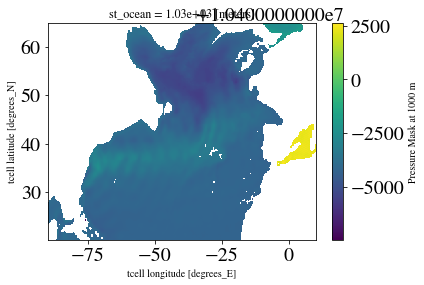

In [36]:
g = 9.81
nz, ny, nx = P.shape

P_temp = np.zeros(((nz,ny,nx)))
P_zero = rho_mat.isel(st_ocean = 0) * g * eta
P_zero_array = P_zero.values
P_zero_array[P_zero_array < 0] = 0

P_temp[0,:,:] = (P_zero_array*(((dz[0,:,:] - eta).values) - Z[0]) + P[0,:,:] * (Z[0]))/((dz[0,:,:] - eta).values)
P_temp[1:,:,:] = (P[1:,:,:].values * (Z[1:] - (np.cumsum(dz, axis = 0)[0:-1,:,:] - eta).values) + P[0:-1,:,:].values * ((
    np.cumsum(dz, axis = 0)[1:,:,:] - eta).values - Z[1:]))/((np.cumsum(dz,axis = 0)[1:,:,:].values - np.cumsum(dz,axis = 0)[0:-1,:,:].values))

z_temp_arr = (P_temp/(rho_mat.values))/g

for i in range(6,nz):
    z_temp_arr[i][z_temp_arr[i] < 0.95*z[i].values] = np.nan
z_test = xr.DataArray(z_temp_arr, coords = [z, y, x],  dims = ['st_ocean','yt_ocean', 'xt_ocean'], 
                            name = 'Depth masked array', attrs = {'units':'m'})

mask = np.isnan(z_test).astype(float)
mask_Arr = mask.values
mask_Arr[mask_Arr == 1] = np.nan
mask_Arr[mask_Arr == 0] = 1
mask_DA = xr.DataArray(mask_Arr, coords = [z, y, x],  dims = ['st_ocean','yt_ocean', 'xt_ocean'], 
                            name = 'Pressure Mask at 1000 m', attrs = {'units':'None'})
P_masked = mask_DA*P_temp

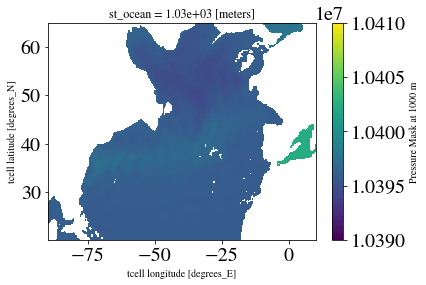

In [38]:
P_masked.sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65)).sel(st_ocean = 1000, method = 'nearest').plot(vmin = 1.039e7, vmax = 1.041e7)

In [40]:
import xgcm

P = P.rename('Pressure')
u = u.rename('Zonal velocity')
v = v.rename('Meridional velocity')

paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
data = xr.merge((rho_mat, u, v, P))
data.coords['xu_ocean'].attrs.update(axis = 'X')
data.coords['xt_ocean'].attrs.update(axis = 'X', c_grid_axis_shift = 0.5)
data.coords['yu_ocean'].attrs.update(axis = 'Y')
data.coords['yt_ocean'].attrs.update(axis = 'Y', c_grid_axis_shift = 0.5)
data.coords['sw_ocean'].attrs.update(axis = 'Z')
data.coords['st_ocean'].attrs.update(axis = 'Z', c_grid_axis_shift = 0.5)

g = xgcm.Grid(data, periodic = ['X'])
temp = g.interp(u, 'X')
u_itp = g.interp(temp, 'Y', boundary = "extend")

g = xgcm.Grid(data, periodic = ['Y'])
temp = g.interp(v, 'Y')
v_itp = g.interp(temp, 'X', boundary = "extend")

g = xgcm.Grid(data, periodic = ['Z'])
P_itp = g.interp(P, 'Z')

## Geostrophic velocity check

In [41]:
rho0 = 1036
omega = (2 * np.pi)/86400
f = 2*omega*np.sin((T.yt_ocean*np.pi)/180)

dPdx = P_masked.differentiate('xt_ocean')*(180/np.pi)/(r0*np.cos((P.yt_ocean*np.pi)/180))
dPdy = P_masked.differentiate('yt_ocean')*(180/np.pi)/r0

dPdx_naive = P_itp.differentiate('xt_ocean')*(180/np.pi)/(r0*np.cos((P.yt_ocean*np.pi)/180))
dPdy_naive = P_itp.differentiate('yt_ocean')*(180/np.pi)/r0

In [62]:
ugx = -(1/(rho0 * f)) * dPdy
vgx = (1/(rho0 * f)) * dPdx

Text(0, 0.5, '')

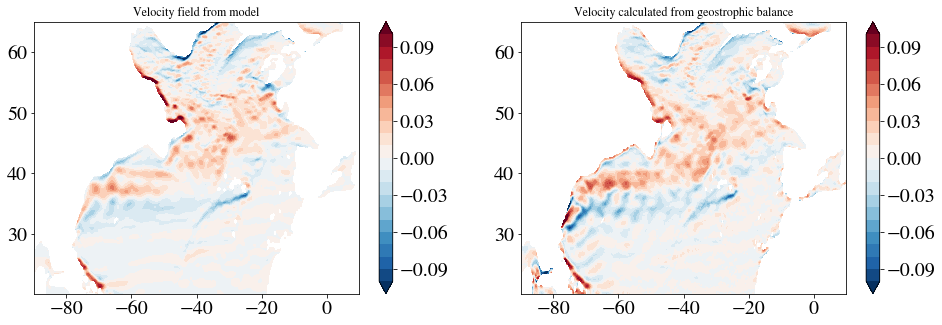

In [68]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

u_itp.rename('').sel(st_ocean = 1000, method = 'nearest').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65)).plot.contourf(
    ax = axes[0], levels = np.linspace(-0.1, 0.1, 21))
ugx.sel(st_ocean = 1000, method = 'nearest').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65)).plot.contourf(
    ax = axes[1], levels = np.linspace(-0.1, 0.1, 21))
axes[0].set_title('Velocity field from model')
axes[1].set_title('Velocity calculated from geostrophic balance')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

Text(0, 0.5, '')

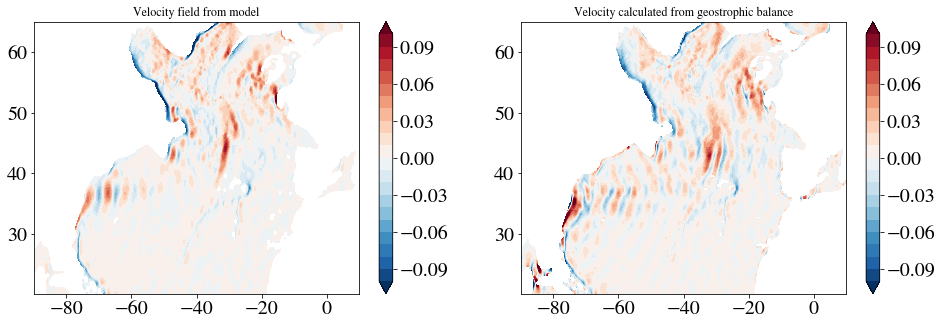

In [66]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

v_itp.rename('').sel(st_ocean = 1000, method = 'nearest').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65)).plot.contourf(
    ax = axes[0], levels = np.linspace(-0.1, 0.1, 21))
vgx.sel(st_ocean = 1000, method = 'nearest').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65)).plot.contourf(
    ax = axes[1], levels = np.linspace(-0.1, 0.1, 21))
axes[0].set_title('Velocity field from model')
axes[1].set_title('Velocity calculated from geostrophic balance')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

## Thermal wind check

In [70]:
drhodx = rho_mat.differentiate('xt_ocean')*(180/np.pi)/(r0*np.cos((P.yt_ocean*np.pi)/180))
drhody = rho_mat.differentiate('yt_ocean')*(180/np.pi)/r0

In [72]:
dudz = u.differentiate('st_ocean', edge_order = 2)
dvdz = v.differentiate('st_ocean', edge_order = 2)

In [77]:
dudz = u_itp.differentiate('st_ocean', edge_order = 2)
dvdz = v_itp.differentiate('st_ocean', edge_order = 2)

dudz_RHS = -(grav/(f * rho0)) * drhody
dvdz_RHS = (grav/(f * rho0)) * drhodx

Text(0, 0.5, '')

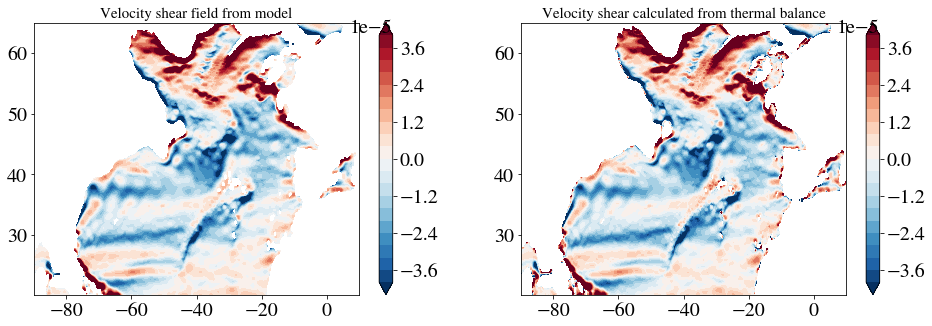

In [90]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

dudz.rename('').sel(st_ocean = 1000, method = 'nearest').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65)).plot.contourf(
    ax = axes[0], levels = np.linspace(-4e-5, 4e-5, 21))
dudz_RHS.sel(st_ocean = 1000, method = 'nearest').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65)).plot.contourf(
    ax = axes[1], levels = np.linspace(-4e-5, 4e-5, 21))
axes[0].set_title('Velocity shear field from model', fontsize = 15)
axes[1].set_title('Velocity shear calculated from thermal balance', fontsize = 15)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

Text(0, 0.5, '')

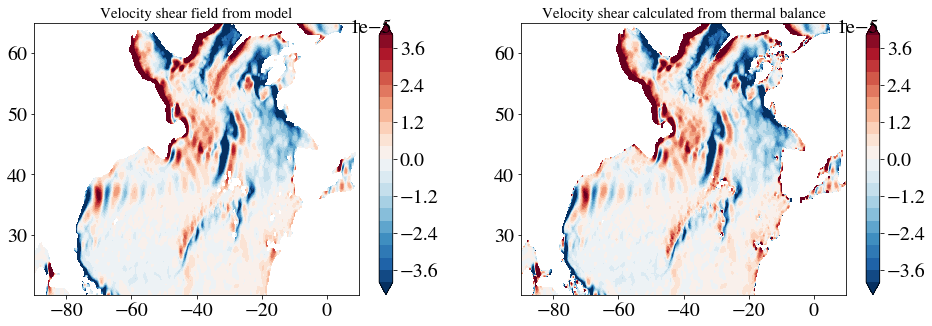

In [91]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))

dvdz.rename('').sel(st_ocean = 1000, method = 'nearest').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65)).plot.contourf(
    ax = axes[0], levels = np.linspace(-4e-5, 4e-5, 21))
dvdz_RHS.sel(st_ocean = 1000, method = 'nearest').sel(xt_ocean = slice(-90, 10)).sel(yt_ocean = slice(20, 65)).plot.contourf(
    ax = axes[1], levels = np.linspace(-4e-5, 4e-5, 21))
axes[0].set_title('Velocity shear field from model', fontsize = 15)
axes[1].set_title('Velocity shear calculated from thermal balance', fontsize = 15)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_ylabel('')